
[INFO] Memproses population_million and urbanization_pct tahun 2000.png...
  -> ⚠ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: 3388 titik data untuk 'population_million' diekstrak.
  -> ✅ Sukses: 3388 titik data untuk 'urbanization_pct' diekstrak.

[INFO] Memproses population_million and urbanization_pct tahun 2001.png...
  -> ⚠ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: 3388 titik data untuk 'population_million' diekstrak.
  -> ✅ Sukses: 3388 titik data untuk 'urbanization_pct' diekstrak.

[INFO] Memproses population_million and urbanization_pct tahun 2002.png...
  -> ⚠ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠ Perin

C:\Users\VICTUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


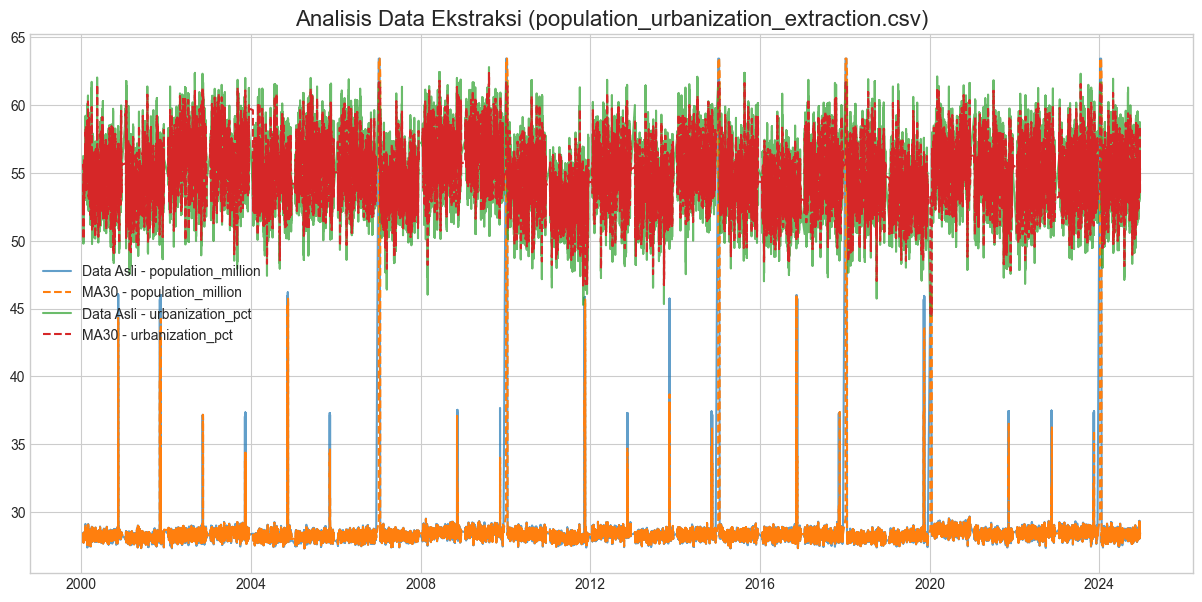


✅ SUKSES! 873168 baris data disimpan ke population_urbanization_extraction.csv


In [2]:
# ==============================================================================
# Script Ekstraksi Data Grafik v7.1 (Multi-Seri, Akurasi Tinggi)
# Deskripsi:
#   Menggunakan deteksi kontur untuk menemukan area plot secara otomatis dan
#   kalibrasi sumbu Y dinamis. Disesuaikan untuk mengekstrak dua seri data
#   berdasarkan warna garisnya dengan akurasi yang ditingkatkan.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# (Letakkan blok CONFIG dari atas di sini)
CONFIG = {
    "folder_path": r"C:\Users\VICTUS\Downloads\Big-data\Data\C10\population_million and urbanization_pct",
    "output_csv_file": "population_urbanization_extraction.csv",
    "fallback_y_min": 25.0,
    "fallback_y_max": 65.0,
    "clamp_y_min": 25.0,
    "clamp_y_max": 65.0,
    "variables": [
        {"name": "population_million", "lower_color": np.array([90, 100, 50]), "upper_color": np.array([120, 255, 255])},  # Garis BIRU
        {"name": "urbanization_pct", "lower_color": np.array([0, 150, 50]), "upper_color": np.array([20, 255, 255])}  # Garis ORANYE
    ],
    "visualize_output": True
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU & PREPROCESSING
# ==============================================================================
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# ==============================================================================
# 3. FUNGSI BARU UNTUK DETEKSI & KALIBRASI OTOMATIS
# ==============================================================================

def find_plot_area(image: np.ndarray) -> Optional[Tuple[np.ndarray, Dict[str, int]]]:
    """
    Mendeteksi area plot utama pada gambar grafik secara otomatis.
    Returns:
        Tuple berisi (gambar area plot yang dipotong, dictionary koordinat) atau None.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    if w > image.shape[1] * 0.5 and h > image.shape[0] * 0.5:
        plot_area_img = image[y:y+h, x:x+w]
        coords = {'x': x, 'y': y, 'w': w, 'h': h}
        return plot_area_img, coords
    return None

def calibrate_yaxis(image: np.ndarray, plot_coords: Dict[str, int]) -> Optional[Dict[str, float]]:
    """
    Mengkalibrasi sumbu Y dengan mendeteksi garis grid dan membaca label OCR.
    Returns:
        Dictionary berisi parameter kalibrasi atau None jika gagal.
    """
    try:
        yaxis_x_end = plot_coords['x']
        yaxis_crop = image[plot_coords['y']:plot_coords['y']+plot_coords['h'], 0:yaxis_x_end]

        gray_yaxis = cv2.cvtColor(yaxis_crop, cv2.COLOR_BGR2GRAY)
        ocr_text = pytesseract.image_to_string(gray_yaxis, config='--psm 6')
        ocr_numbers = sorted([float(n) for n in re.findall(r'\b\d+\.?\d*\b', ocr_text)], reverse=True)
        
        if len(ocr_numbers) < 2: return None

        plot_gray = cv2.cvtColor(image[plot_coords['y']:plot_coords['y']+plot_coords['h'], plot_coords['x']:plot_coords['x']+plot_coords['w']], cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(plot_gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=plot_coords['w']*0.8, maxLineGap=10)

        if lines is None: return None

        grid_y_coords = sorted(list(set([line[0][1] for line in lines])))
        
        if len(grid_y_coords) >= 2 and len(ocr_numbers) >= 2:
            top_line_y, bottom_line_y = grid_y_coords[0], grid_y_coords[-1]
            top_val, bottom_val = ocr_numbers[0], ocr_numbers[-1]
            
            pixel_span = bottom_line_y - top_line_y
            value_span = top_val - bottom_val
            
            if pixel_span == 0 or value_span == 0: return None

            pixels_per_value = pixel_span / value_span
            
            calibrated_y_max = top_val + ((top_line_y - (plot_coords['y']-top_line_y)) / pixels_per_value)
            calibrated_y_min = calibrated_y_max - (plot_coords['h'] / pixels_per_value)
            
            print(f"  -> ✅ Kalibrasi Sumbu Y berhasil: Min={calibrated_y_min:.2f}, Max={calibrated_y_max:.2f}")
            return {'min': calibrated_y_min, 'max': calibrated_y_max}
            
    except Exception as e:
        print(f"  -> ⚠ Peringatan Kalibrasi: {e}")
    return None

# ==============================================================================
# 4. FUNGSI EKSTRAKSI & PEMROSESAN
# ==============================================================================

def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            
            day_of_year = int(round((x_pixel / plot_w) * days_in_year))
            date = start_date + timedelta(days=day_of_year)
            
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"),
                "Year": params['year'],
                "DayOfYear": day_of_year + 1,
                params['var_name']: round(value, 2)
            })
    return pd.DataFrame(extracted_data)
    
def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Date'])
    proc_df = proc_df.sort_values(by='Date').set_index('Date')
    
    # Interpolasi dan rata-rata bergerak untuk setiap seri
    for var_info in config.get('variables', []):
        var_name = var_info['name']
        if var_name in proc_df.columns:
            proc_df[var_name] = proc_df[var_name].interpolate(method='time')
            proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
            
    return proc_df.dropna(how='all')

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    
    for var_info in config.get('variables', []):
        var_name = var_info['name']
        if var_name in df.columns:
            ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7)
            if f'{var_name}_MA30' in df.columns:
                ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================

def main(config: Dict[str, Any]):
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return

    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.endswith((".png", ".jpg", ".jpeg"))])
    
    all_results = pd.DataFrame()
    for filename in all_files:
        print(f"\n[INFO] Memproses {filename}...")
        full_path = os.path.join(config['folder_path'], filename)
        img = cv2.imread(full_path)
        if img is None: continue

        plot_info = find_plot_area(img)
        if not plot_info:
            print("  -> ⚠ Peringatan: Area plot tidak terdeteksi, file dilewati.")
            continue
        plot_area, plot_coords = plot_info
        
        calibration = calibrate_yaxis(img, plot_coords)
        if calibration:
            y_min, y_max = calibration['min'], calibration['max']
        else:
            print("  -> ⚠ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.")
            y_min, y_max = config['fallback_y_min'], config['fallback_y_max']

        year_from_file = int(re.search(r'(\d{4})', filename).group(1))
        
        series_data = []
        for var_info in config['variables']:
            hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
            lower_color = var_info['lower_color']
            upper_color = var_info['upper_color']
            
            mask = cv2.inRange(hsv, lower_color, upper_color)
            mask_cleaned = clean_mask(mask)
            
            series_params = {
                'year': year_from_file, 'y_min': y_min, 'y_max': y_max,
                'clamp_y_min': config['clamp_y_min'], 'clamp_y_max': config['clamp_y_max'],
                'var_name': var_info['name']
            }
            
            df_series = extract_series_from_mask(mask_cleaned, series_params)
            if not df_series.empty:
                series_data.append(df_series)
                print(f"  -> ✅ Sukses: {len(df_series)} titik data untuk '{var_info['name']}' diekstrak.")
        
        if series_data:
            df_combined = series_data[0]
            for df_s in series_data[1:]:
                df_combined = pd.merge(df_combined, df_s, on=['Date', 'Year', 'DayOfYear'], how='outer')
            all_results = pd.concat([all_results, df_combined], ignore_index=True)

    if all_results.empty: 
        print("\n⚠ PROSES SELESAI: Tidak ada data yang berhasil diekstrak."); 
        return
    
    analyzed_df = post_process_data(all_results, config)
    if config.get('visualize_output', True): 
        visualize_results(analyzed_df, config)
    
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

if __name__ == '__main__':
    main(CONFIG)